In [ ]:
import BALROG_pipeline as bp
import torch 
import numpy as np
import pandas as pd
import seaborn as sb
import torchvision
from rembg import new_session
import matplotlib.pyplot as plt
bg_session = new_session()

In [2]:
# Load model
model = torch.load("models/final_models/model_2_deft-bird-19.pt", map_location=torch.device('cpu'), weights_only=False)

# Read corresponding test data
df = pd.read_pickle("results/final_models/test_df_2.pkl")
df["Image ID"] = [x.split("/")[-1].split(".")[0].split("_")[-1] for x in df["PATH"].values]
df_ref = pd.read_pickle("data/references/database_reference_MLREADY.pkl")

# Merge dataframes to get metadata for the test set
df_merged = pd.merge(df, df_ref, on="Image ID", how="inner")

In [3]:
# Select 12 images from each class
df_sample = df_merged.loc[df_merged["Project"] == "CNN-Study"].groupby("LABEL").apply(lambda x: x.sample(12, replace=True)).reset_index(drop=True)

grad_dict, guided_dict, image_dict = {}, {}, {}
for label in df_sample["LABEL"].unique():
    grad_ls, guided_ls, image_ls = [], [], []
    path_ls = df_sample.loc[df_sample["LABEL"] == label, "PATH"].values
    for path in path_ls:
        # Load and preprocess image with pipeline
        image = bp.image_preprocessing_pipeline("MosquitoWingDataset/" + path, bg_session)
        image = torchvision.transforms.functional.resize(image, (192, 384))
        species_list = np.asarray(bp.get_species_list())
        class_idx = np.argmax(label == species_list)

        # Create guided backpropagation and grad-CAM
        grayscale_cam, guided_grads = bp.create_guided_cam(model, image.unsqueeze(0), class_idx)

        # Append to lists
        grad_ls.append(grayscale_cam)
        guided_ls.append(guided_grads)
        image_ls.append(image[0])

    grad_dict[label] = grad_ls
    guided_dict[label] = guided_ls
    image_dict[label] = image_ls

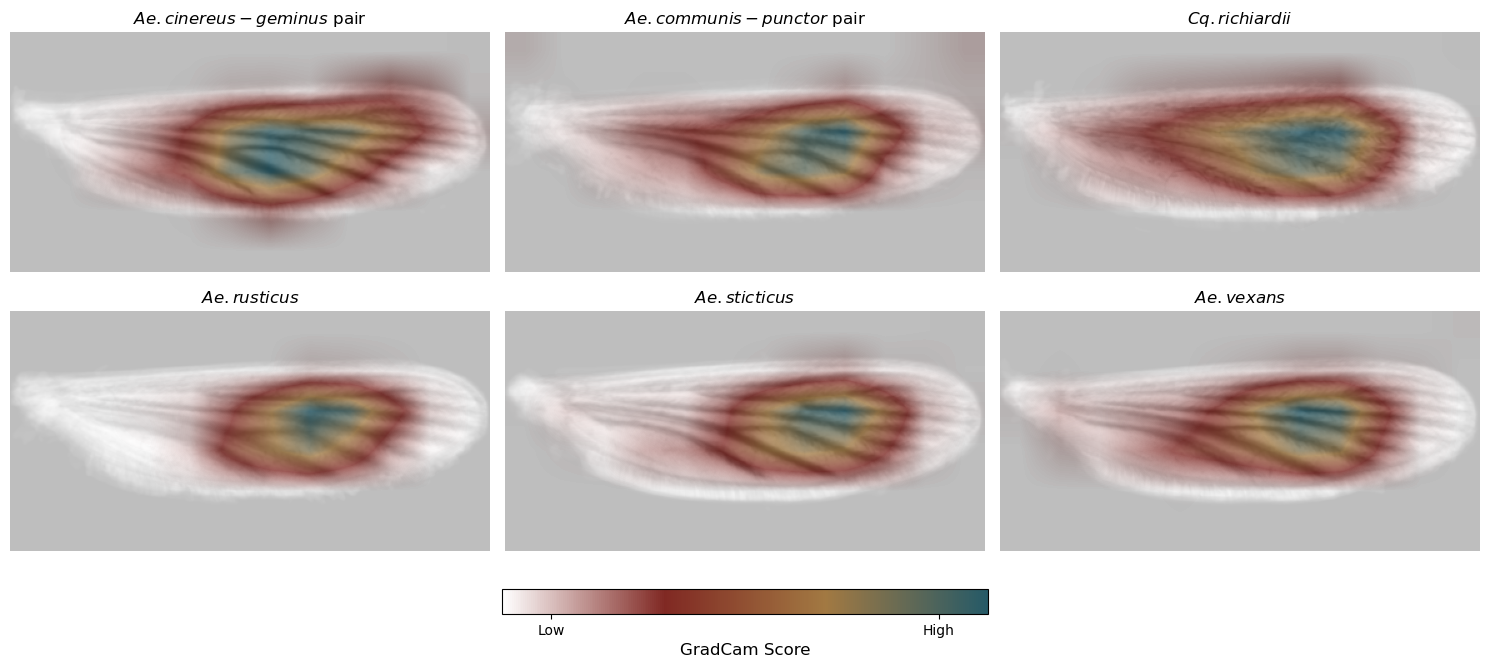

In [34]:
# Figure 6
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
ax = axes.flatten()

# Create custom species format so species names are italicized
species_format_ls = ['$\\it{Ae. cinereus-geminus\\ }$pair', '$\\it{Ae. communis-punctor\\ }$pair', '$\\it{Cq. richiardii}$',
                     '$\\it{Ae. rusticus}$', '$\\it{Ae. sticticus}$', '$\\it{Ae. vexans}$']

# Create the custom palette
colors = ["white", "#802823", "#A27942", "#265A67"]
custom_palette = sb.blend_palette(colors, as_cmap=True)

for i, key in enumerate(['cinereus-geminus-pair', 'communis-punctor-pair', 'richiardii', 'rusticus', 'sticticus', 'vexans']):
    ax[i].imshow(np.mean(image_dict[key],axis=0), cmap="gray")
    ax[i].imshow(np.mean(grad_dict[key],axis=0), alpha=0.75, cmap=custom_palette)
    ax[i].axis("off")
    ax[i].set_title(species_format_ls[i], fontsize=12,)


plt.tight_layout()

# Add a colorbar showing the costum palette
# Colorbar should be positioned at the bottom of the figure, outside of the images
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=custom_palette), ax=ax,
                    orientation="horizontal",
                    location="bottom", shrink=0.33, pad=0.05)

cbar.set_ticks([0.1, 0.9])
cbar.set_ticklabels(["Low", "High"])
cbar.set_label("GradCam Score", fontsize=12)

plt.savefig("figures/Figure_6-CAM.png", dpi=300)

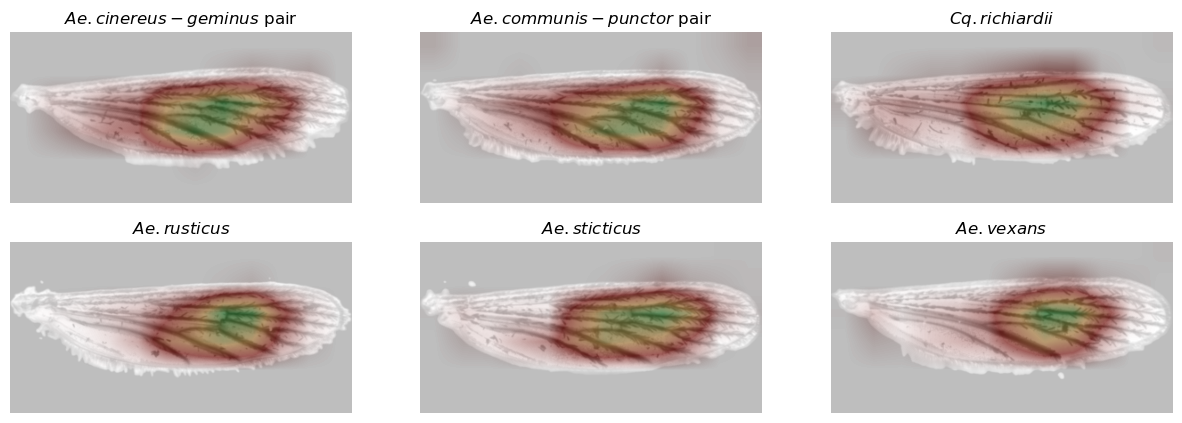

In [12]:
# Show some individual examples of the CAMs
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
ax = axes.flatten()

for i, key in enumerate(['cinereus-geminus-pair', 'communis-punctor-pair', 'richiardii', 'rusticus', 'sticticus', 'vexans']):
    ax[i].imshow(image_dict[key][0], cmap="gray")
    ax[i].imshow(grad_dict[key][0], alpha=0.75, cmap=custom_palette)
    ax[i].set_title(key)
    ax[i].axis("off")
    ax[i].set_title(species_format_ls[i], fontsize=12)